In [5]:
# Import data

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from hevisum_dataset import importDataset
import numpy as np



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/envs/spatialhackathon/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/envs/spatialhackathon/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/traitlets/config/application.py", lin

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch

# 載入資料
data = torch.load("train_dataset.pt")

# ====== Step 1: Normalize 座標 ======
raw_coords = np.array([
    [x if meta is not None else 0, y if meta is not None else 0]
    for _, x, y in data['meta_info']
])

coord_scaler = StandardScaler()
normalized_coords = coord_scaler.fit_transform(raw_coords)

# ====== Step 2: 建立 Dataset ======
train_dataset = importDataset(
    center_tile=data['tiles'],
    subtiles=data['subtiles'],
    neighbor_tiles=data['neighbor_tiles'],
    label=data['labels'],
    meta=normalized_coords
)

In [4]:
def check_dataset_item(dataset, idx=0):
    item = dataset[idx]

    print("🔍 Checking dataset sample:", idx)

    tile = item['center_tile']
    print(f"📏 Center tile shape: {tile.shape} | dtype: {tile.dtype} | min: {tile.min():.3f}, max: {tile.max():.3f}")
    assert tile.ndim == 3 and tile.shape[0] == 3, "❌ Center tile shape 不正確，應為 (3, H, W)"

    subtiles = item['subtiles']
    print(f"📏 Subtiles shape: {subtiles.shape} | dtype: {subtiles.dtype}")
    assert subtiles.shape[1] == 3, "❌ Subtile shape 不正確，應為 (9, 3, h, w)"

    neighbors = item['neighbor_tiles']
    print(f"📏 Neighbor tiles shape: {neighbors.shape} | dtype: {neighbors.dtype}")
    assert neighbors.shape[1] == 3, "❌ Neighbor tile shape 不正確，應為 (8, 3, H, W)"

    label = item['label']
    print(f"🧬 Label shape: {label.shape} | dtype: {label.dtype}")
    assert label.shape[0] == 35 and label.dtype == torch.float32, "❌ Label 應為 float32 且長度為 35"

    coordinates = item['meta']
    print(f"🧬 x: {coordinates[0]}, y: {coordinates[1]}")

    print("✅ All checks passed!")
    
check_dataset_item(train_dataset, idx=0)


RuntimeError: Numpy is not available

In [ ]:
from torch.utils.data import DataLoader, random_split

# 設定比例
train_ratio = 0.8
val_ratio = 1 - train_ratio
total_len = len(train_dataset)
train_len = int(train_ratio * total_len)
val_len = total_len - train_len

# 拆分 Dataset
generator = torch.Generator().manual_seed(42)
train_set, val_set = random_split(train_dataset, [train_len, val_len], generator=generator)

print(f"✅ Train: {len(train_set)} samples")
print(f"✅ Val: {len(val_set)} samples")

# 🔹 將其包成 DataLoader
BATCH_SIZE = 32

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)


✅ Train: 6679 samples
✅ Val: 1670 samples


Poteintial issues:
# 1. my val_set tiles image may be included in the sub_tiles of train_set

Note: Since neighbor tiles are reused across samples, some mild information overlap may exist between train and val sets. However, final test set is completely held out.

# model 

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from torchvision.models import ResNet18_Weights

class SafeTransform:
    def __init__(self):
        self.normalize = transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)

    def __call__(self, img):
        if isinstance(img, np.ndarray):
            img = torch.from_numpy(img.transpose(2, 0, 1)).float() / 255.0
        elif isinstance(img, torch.Tensor):
            if img.shape[0] != 3:  # HWC → CHW
                img = img.permute(2, 0, 1).float()
            else:
                img = img.float()
        else:
            raise ValueError(f"Unsupported image type: {type(img)}")
        return self.normalize(img)

# ✅ 建立 ResNet18 encoder（不含分類頭）
def get_resnet_encoder(output_dim=128):
    resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)  # 或改成 weights='DEFAULT' 如果你要 pretrained
    layers = list(resnet.children())[:-2]  # 去掉 GAP + FC
    cnn = nn.Sequential(*layers)
    gap = nn.AdaptiveAvgPool2d(1)
    flatten = nn.Flatten()
    linear = nn.Linear(512, output_dim)
    encoder = nn.Sequential(cnn, gap, flatten, linear)
    return encoder

# ✅ 基本 image transform
transform = transforms.Compose([
    transforms.ToTensor(),  # (H, W, C) → (C, H, W)
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# ✅ 特徵提取函數
def extract_feature(encoder, tile_list, device):
    encoder.eval()
    feats = []
    with torch.no_grad():
        for tile in tile_list:
            img = transform(tile).unsqueeze(0).to(device)
            feat = encoder(img).cpu().numpy()
            feats.append(feat[0])
    return np.array(feats)

def extract_all_features(dataset, encoder, device):
    encoder.eval()
    all_features = []
    all_labels = []
    transform = SafeTransform()

    for sample in tqdm(dataset, desc="Extracting features"):
        with torch.no_grad():
            # Center tile
            spot_img = transform(sample['center_tile']).unsqueeze(0).to(device)
            spot_feat = encoder(spot_img).cpu().numpy()[0]

            # Sub-tiles (取平均)
            subtiles = sample['subtiles']
            subtile_imgs = torch.stack([transform(t) for t in subtiles]).to(device)
            sub_feat = encoder(subtile_imgs).cpu().numpy().mean(axis=0)

            # Neighbor tiles (取平均)
            neighbors = sample['neighbor_tiles']
            neighbor_imgs = torch.stack([transform(t) for t in neighbors]).to(device)
            neighbor_feat = encoder(neighbor_imgs).cpu().numpy().mean(axis=0)

            # Coordinates (x, y)
            if sample['meta'] is not None:
                _, x, y = sample['meta']
            else:
                x, y = 0, 0
            coord_feat = np.array([x, y])

            # 拼起來
            full_feat = np.concatenate([spot_feat, sub_feat, neighbor_feat, coord_feat])  # shape: (128*3 + 2,)
            all_features.append(full_feat)
            all_labels.append(sample['label'].numpy())

    return np.array(all_features), np.array(all_labels)



In [149]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = get_resnet_encoder(output_dim=128).to(device)
# 提取 train 特徵
X_train, y_train = extract_all_features(train_set, encoder, device)

# 提取 val 特徵
X_val, y_val = extract_all_features(val_set, encoder, device)


Extracting features: 100%|██████████| 1670/1670 [01:29<00:00, 18.72it/s]


In [157]:
# ===== 📚 所需 Library =====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr

# ===== 🔧 訓練模型（支援 Spearman & MLP loss 曲線） =====
def train_models(X_train, y_train, X_val, y_val):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    models = {
        'Lasso': Lasso(alpha=0.01, max_iter=10000),
        'MLP': MLPRegressor(
            hidden_layer_sizes=(128, 64),
            max_iter=500,
            early_stopping=True,
            random_state=42
        )
    }

    results = {}

    for name, model in models.items():
        print(f"\n🔧 Training {name}...")
        model.fit(X_train_scaled, y_train)

        train_pred = model.predict(X_train_scaled)
        val_pred = model.predict(X_val_scaled)

        train_loss = mean_squared_error(y_train, train_pred)
        val_loss = mean_squared_error(y_val, val_pred)

        # ====== Spearman correlation (平均每一個 spot) ======
        spearman_scores = []
        for i in range(len(y_val)):
            score, _ = spearmanr(y_val[i], val_pred[i])
            spearman_scores.append(score)
        val_spearman = np.nanmean(spearman_scores)

        print(f"✅ {name} | Train MSE: {train_loss:.4f} | Val MSE: {val_loss:.4f} | ρ (Spearman): {val_spearman:.4f}")

        results[name] = {
            'model': model,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_spearman': val_spearman,
            'val_pred': val_pred,
        }

        if name == "MLP":
            results[name]["loss_curve_"] = model.loss_curve_

    return results, X_val_scaled, scaler



🔧 Training Lasso...
✅ Lasso | Train MSE: 0.6201 | Val MSE: 0.6526 | ρ (Spearman): 0.5308

🔧 Training MLP...
✅ MLP | Train MSE: 0.0839 | Val MSE: 0.4405 | ρ (Spearman): 0.5888

🧠 Ensemble Evaluation
✅ Ensemble Val MSE: 0.4457


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_10837/595923715.py:86: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_10837/595923715.py:86: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


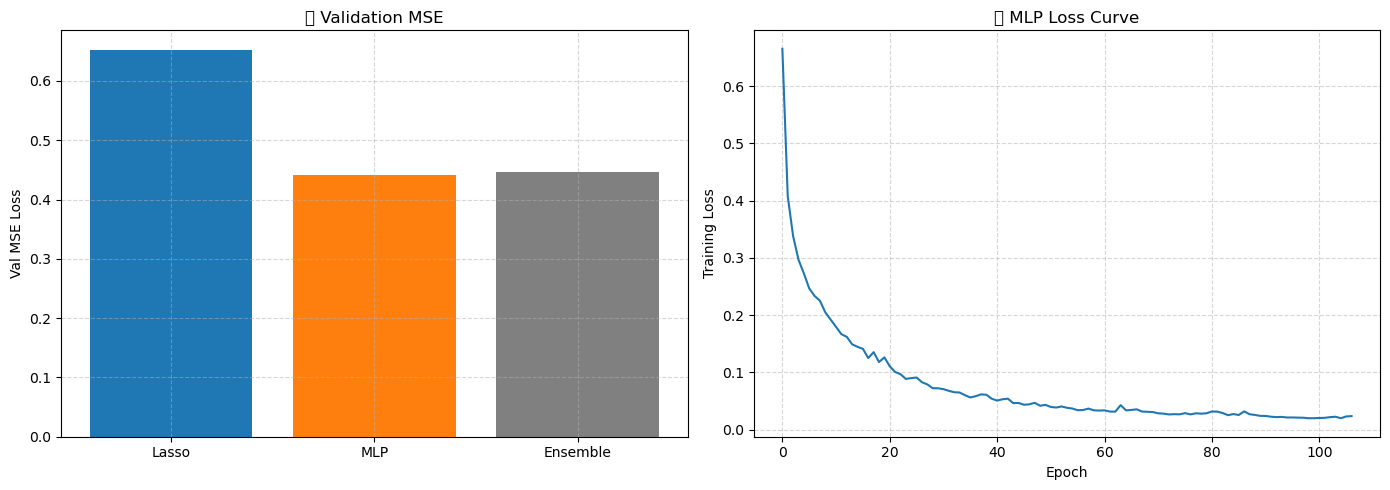

In [158]:
results, X_val_scaled, scaler = train_models(X_train, y_train, X_val, y_val)
ensemble_pred, ensemble_loss = ensemble_predict(results, y_val)
plot_losses(results, ensemble_loss)


In [ ]:

test_dataset = importDataset(
    center_tile=data['tiles'],
    subtiles=data['subtiles'],
    neighbor_tiles=data['neighbor_tiles'],
    label=data['labels'],
    meta=data['meta_info']
)

import torch
import h5py
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# ==== 🔄 抽取 test feature ====
data = torch.load("test_dataset.pt")
test_dataset = importDataset(
    tiles=data['tiles'],
    labels=data['labels'],
    subtiles=data['subtiles'],
    neighbor_tiles=data['neighbor_tiles'],
    meta_info=data['meta_info']
)

# 🧠 提取 image features（要先定義好 encoder, transform, extract_all_features）
X_test, _ = extract_all_features(test_dataset, encoder, device)


In [156]:

# === 用 train 時的 scaler 做 normalize ===
X_test_scaled = scaler.transform(X_test)

# ==== 讀取 test spot index 用於對應 ID ====
with h5py.File("./elucidata_ai_challenge_data.h5", "r") as f:
    test_spots = f["spots/Test"]
    test_spot_table = pd.DataFrame(np.array(test_spots['S_7']))  # Example: S_7

# ==== 多模型推論 + 存檔 ====
test_preds = []
for name, res in results.items():
    model = res['model']
    print(f"📡 Predicting with {name}...")
    
    pred = model.predict(X_test_scaled)
    test_preds.append(pred)
    print(f"{pred[0]}")
    # 建立 dataframe
    df = pd.DataFrame(pred, columns=[f"C{i+1}" for i in range(pred.shape[1])])
    df.insert(0, 'ID', test_spot_table.index)

    # 儲存
    csv_path = f"submission_{name}.csv"
    df.to_csv(csv_path, index=False)
    print(f"✅ Saved {csv_path}")

# === Ensemble 預測 ===
avg_pred = np.mean(test_preds, axis=0)
ensemble_df = pd.DataFrame(avg_pred, columns=[f"C{i+1}" for i in range(avg_pred.shape[1])])
ensemble_df.insert(0, 'ID', test_spot_table.index)
ensemble_df.to_csv("submission_Ensemble.csv", index=False)
print("✅ Saved submission_Ensemble.csv")


📡 Predicting with Ridge...
[-3.51106367e-01  2.18854823e-01 -3.23466164e-01  8.18276817e-02
  6.01725037e-01  3.50780903e-01  5.66899790e-02  8.94740584e-02
 -2.03149321e-01  1.19813856e-01  2.00108885e-01  4.51481854e-02
  2.75789539e-02  1.44488468e-01  4.06978223e-01  2.87420661e+00
  3.65545082e-01 -1.04463868e-02  6.35353536e-02  4.02402231e-02
  2.65233889e-02 -2.14924867e-03  1.62630324e-01  2.50158443e-01
  7.19816766e-01  1.32521112e-01 -8.75614677e-02  5.25253840e-02
  4.89432823e-02  3.11216738e-01  1.22638374e-01  9.88457346e-02
  7.55199807e-02  3.75154725e-02  5.72495963e-02]
✅ Saved submission_Ridge.csv
📡 Predicting with Lasso...
[-0.78519205  0.15300198 -0.72065905 -0.02037183 -0.01132746  0.22057727
  0.02593226  0.01973279 -0.07578304  0.01716047  0.25540597 -0.00402607
  0.01227694  0.11649104  0.0198984   2.12134967  0.51371193 -0.04704631
  0.07739604  0.03454518  0.01942443  0.02322509  0.10786618  0.09772463
  0.62697348  0.08460851  0.0318248   0.01678285 -0.015

In [112]:
# 2. 用跟 train 一樣的 scaler 做標準化
X_test_scaled = scaler.transform(X_test)

# 3. 用訓練好的 RANSACRegressor 預測
y_test_pred = ransac.predict(X_test_scaled)
y_test_pred[0]

array([ 1.71574386e+03, -8.71038191e+01, -1.12221154e+03,  6.66099615e+02,
        1.93833238e+03,  2.89004042e+02,  7.24149650e+01,  1.54272632e+01,
        4.70915200e+02, -4.81328111e+02, -1.73361275e+02,  9.03447916e+01,
        3.18707376e+01, -4.39469362e+02,  1.92447958e+02,  2.59601106e+03,
       -1.01561150e+02, -6.53646537e+01, -3.54803312e-01,  1.99997121e+02,
       -5.53696969e+01, -1.83644161e+02, -6.97003663e+01, -4.88538183e+02,
       -3.00518974e+02, -2.84042161e+02,  5.02796469e+01, -8.58359136e+01,
        7.74208788e+01, -3.64280331e+02, -1.56087249e+02, -4.94379699e+01,
       -1.99022845e+02,  3.56846444e+01, -5.37282884e+00])

In [ ]:
# Load test data
with h5py.File("./elucidata_ai_challenge_data.h5", "r") as f:
    test_spots = f["spots/Test"]
    test_spot_table = pd.DataFrame(np.array(test_spots['S_7']))  # Example slide S_7
# Prepare submission file
submission_df = pd.DataFrame(y_test_pred, columns=y.columns)
submission_df.insert(0, 'ID', test_spot_table.index)
submission_df.to_csv("./submission.csv", index=False)
print("Submission file 'submission.csv' created!")

Submission file 'submission.csv' created!


# Neural Network

In [185]:
import torch
import torch.nn as nn

class CNNEncoder(nn.Module):
    def __init__(self, out_dim):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(64, out_dim)

    def forward(self, x):  # x: (B, 3, H, W)
        x = self.cnn(x)     # → (B, 64, 1, 1)
        x = self.flatten(x) # → (B, 64)
        x = self.linear(x)  # → (B, out_dim)
        return x

class MLPDecoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)  # 👉 Linear activation
        )

    def forward(self, x):
        return self.mlp(x)

class VisionMLPModelWithCoord(nn.Module):
    def __init__(self, cnn_out_dim=64, output_dim=35):
        super().__init__()
        self.encoder_spot = CNNEncoder(cnn_out_dim)
        self.encoder_subtiles = CNNEncoder(cnn_out_dim)
        self.encoder_neighbors = CNNEncoder(cnn_out_dim)

        # Input to decoder: 3 * cnn_out_dim + 2 (for x, y)
        self.decoder = MLPDecoder(input_dim=cnn_out_dim * 3 + 2, output_dim=output_dim)

    def forward(self, center_tile, subtiles, neighbor_tiles, coords):
        # center_tile: (B, 3, H, W)
        # subtiles: (B, 9, 3, h, w)
        # neighbor_tiles: (B, 8, 3, H, W)
        # coords: (B, 2)

        B = center_tile.size(0)

        # Spot
        f_center = self.encoder_spot(center_tile)  # (B, D)

        # Subtiles
        B, N, C, h, w = subtiles.shape
        subtiles = subtiles.view(B * N, C, h, w)
        f_sub = self.encoder_subtiles(subtiles).view(B, N, -1).mean(dim=1)  # (B, D)

        # Neighbors
        B, N, C, H, W = neighbor_tiles.shape
        neighbor_tiles = neighbor_tiles.view(B * N, C, H, W)
        f_neigh = self.encoder_neighbors(neighbor_tiles).view(B, N, -1).mean(dim=1)  # (B, D)

        # Concatenate with coordinates
        x = torch.cat([f_center, f_sub, f_neigh, coords], dim=1)  # (B, 3D+2)
        out = self.decoder(x)  # (B, 35)
        return out


In [ ]:
import torch
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm

def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    pbar = tqdm(dataloader, desc="Training", leave=False)

    for batch in pbar:
        center = batch['center_tile'].to(device)
        subtiles = batch['subtiles'].to(device)
        neighbors = batch['neighbor_tiles'].to(device)
        label = batch['label'].to(device)

        # ➕ 新增座標：meta 中的 x, y
        coords = []
        for meta in batch['meta']:
            if meta is not None:
                x, y = meta
            else:
                x, y = 0, 0
            coords.append([x, y])
        coords = torch.tensor(coords, dtype=torch.float32).to(device)

        # ➤ forward + backward
        optimizer.zero_grad()
        out = model(center, subtiles, neighbors, coords)
        loss = loss_fn(out, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * center.size(0)
        avg_loss = total_loss / ((pbar.n + 1) * dataloader.batch_size)
        pbar.set_postfix(loss=loss.item(), avg=avg_loss)

    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss


def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    preds = []
    targets = []

    pbar = tqdm(dataloader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for batch in pbar:
            center = batch['center_tile'].to(device)
            subtiles = batch['subtiles'].to(device)
            neighbors = batch['neighbor_tiles'].to(device)
            label = batch['label'].to(device)

            coords = []
            for meta in batch['meta']:
                if meta is not None:
                    x, y = meta
                else:
                    x, y = 0, 0
                coords.append([x, y])
            coords = torch.tensor(coords, dtype=torch.float32).to(device)

            out = model(center, subtiles, neighbors, coords)
            loss = loss_fn(out, label)

            total_loss += loss.item() * center.size(0)
            preds.append(out.cpu())
            targets.append(label.cpu())

            pbar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(dataloader.dataset)
    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()

    scores = [spearmanr(preds[:, i], targets[:, i])[0] for i in range(preds.shape[1])]
    spearman_avg = np.nanmean(scores)

    return avg_loss, spearman_avg


def predict(model, dataloader, device):
    model.eval()
    all_preds = []
    all_meta = []

    with torch.no_grad():
        for batch in dataloader:
            center = batch['center_tile'].to(device)
            subtiles = batch['subtiles'].to(device)
            neighbors = batch['neighbor_tiles'].to(device)

            coords = []
            for meta in batch['meta']:
                if meta is not None:
                    _, x, y = meta
                else:
                    x, y = 0, 0
                coords.append([x, y])
            coords = torch.tensor(coords, dtype=torch.float32).to(device)

            out = model(center, subtiles, neighbors, coords)
            all_preds.append(out.cpu())
            all_meta.extend(batch['meta'])

    preds = torch.cat(all_preds).numpy()
    return preds, all_meta


# callback

In [192]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=True):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_loss):
        if self.best_score is None or val_loss < self.best_score:
            self.best_score = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

import matplotlib.pyplot as plt
from IPython.display import clear_output


def plot_losses(train_losses, val_losses):
    clear_output(wait=True)
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label="Train Loss", marker='o')
    plt.plot(val_losses, label="Val Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.title("Training vs Validation Loss")
    plt.show()
# 收集資料

In [195]:
import torch
import csv
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# 🔧 設定裝置
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"✅ Using device: {device}")

# 🔧 初始化模型 & 優化器
model = VisionMLPModelWithCoord().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
early_stopper = EarlyStopping(patience=10)

# 🔧 儲存 log 的設定
log_file = open("training_log.csv", mode="w", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["Epoch", "Train Loss", "Val Loss", "Val Spearman", "Learning Rate"])

# 🔧 用來畫圖
train_losses = []
val_losses = []


# 🔁 開始訓練
num_epochs = 150
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_spearman = evaluate(model, val_loader, loss_fn, device)

    # ✅ 儲存最好的模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        print("✅ Saved best model!")

    # ✅ 調整學習率
    scheduler.step(val_loss)

    # ✅ 寫入 CSV log
    lr = optimizer.param_groups[0]['lr']
    csv_writer.writerow([epoch+1, train_loss, val_loss, val_spearman, lr])

    # ✅ 印 epoch 結果
    print(f"Epoch {epoch+1}/{num_epochs} | loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | ρ: {val_spearman:.4f} | lr: {lr:.2e}")

    # ✅ 更新 loss list 並畫圖
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    plot_losses(train_losses, val_losses)

    # ✅ Early stopping
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("⛔ Early stopping triggered.")
        break

# ✅ 關閉 log 檔案
log_file.close()


✅ Using device: mps


ValueError: could not convert string to float: 'S_5'

In [46]:
val_loss, val_spearman = evaluate(model, val_loader, loss_fn, device)
print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val ρ: {val_spearman:.4f}")


[Epoch 14] Train Loss: 0.1011 | Val Loss: 1.4347 | Val ρ: 0.2025


In [206]:
batch = next(iter(train_loader))

for i, meta in enumerate(batch['meta']):
    print(f"[{i}] meta =", meta, "| type:", type(meta))


[0] meta = ('S_2', 'S_5', 'S_1', 'S_1', 'S_2', 'S_6', 'S_4', 'S_4', 'S_2', 'S_5', 'S_2', 'S_5', 'S_5', 'S_2', 'S_2', 'S_2', 'S_4', 'S_5', 'S_1', 'S_3', 'S_4', 'S_5', 'S_5', 'S_1', 'S_1', 'S_5', 'S_4', 'S_5', 'S_5', 'S_2', 'S_5', 'S_1') | type: <class 'tuple'>
[1] meta = Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_10837/3795159109.py", line 4, in <module>
    print(f"[{i}] meta =", meta, "| type:", type(meta))
  File "/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torch/_tensor.py", line 523, in __repr__
    self, gradient, retain_graph, create_graph, inputs=inputs
  File "/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torch/_tensor_str.py", line 706, in _str
  File "/opt/anaconda3/envs/spatialhackathon/lib/python3.9/contextlib.py", line 119, in __enter__
    return next(self.gen)
  File "/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torch/utils/_python_dispatch.py", line 235, in _disable_current_modes
    alias_non_inplace_storage(args[arg_idx], outs[return_i

In [ ]:
model = HEVisumModel().to(device)
model.load_state_dict(torch.load("best_model.pt"))
model.eval()


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
